In [8]:
# default_exp tearsheets

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# export

import pyfolio
from pyfolio.timeseries import perf_stats, gen_drawdown_table
import numpy as np
import pandas as pd
from path import Path
from pprint import pprint
from functools import reduce
import datetime
import logging
import re

import simplejson as json

from mlbt.historical_bt import simulate_pnl
from mlbt.pnl_sim import get_pnl_reports
from mlbt.feature_eng import engineer_feature

try:
    from mlbt import settings_pers as settings
except:
    from mlbt import settings

FORMAT = "%(asctime)-15s %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

def mean_of_dfs(dfs):
    return reduce(lambda left, right: left.add(right), dfs) / len(dfs)


def make_default_config(**data):
    DATA_DIR = data.get("DATA_DIR", settings.DATA_DIR)

    return {
        "DATA_DIR": DATA_DIR,
        "F_PAYLOAD_DIR": data.get("F_PAYLOAD_DIR", settings.F_PAYLOAD_DIR),
        "symbols_map": pd.read_csv(DATA_DIR / "symbols.csv", index_col="iqsymbol"),
    }

    
def abort_early(force, file_name):
    have_file = False
    if not force:
        try:
            # Check if we already have the file we want to create
            with open(file_name) as f:
                have_file = bool(json.load(f))
        except:
            pass
        if have_file:
            return True
    return False
    

def load_payloads(file_names, our_config):
    res = []
    for file_name in file_names:
        with open(file_name) as f:
            pay_j = json.load(f)

        events = pd.DataFrame.from_dict(pay_j["events"])
        events = events.set_index(pd.to_datetime(events.index))
        events["t1"] = pd.to_datetime(events["t1"])
        config = get_config(pay_j, file_name)
        config = {**config, **our_config}

        closes, clf_signals, alpha_signals = get_pnl_reports(
            events,
            pay_j["symbols"],
            config["binarize"],
            config["binarize_params"],
        )
        logging.info(f"clf_signals shape {clf_signals.shape}")

        primary_signals, secondary_signals = (
            (alpha_signals, clf_signals)
            if alpha_signals is not None
            else (clf_signals, alpha_signals)
        )
        res.append((config, pay_j, events, closes, primary_signals, secondary_signals))

    return res

def join_signals(dfs):
    cols = dfs[0].columns
    signals = []
    for col in cols:
        symbol_signals = pd.concat([df[col] for df in dfs if col in df], axis=1).ffill().mean(axis=1)
        signals.append(symbol_signals)
    res = pd.concat(signals, axis=1).ffill()
    res.columns = cols
    return res


def create_frontend_payload(file_names, force=False, our_config=None):
    if our_config is None:
        our_config = make_default_config()
    
    combine_multi = len(file_names) > 1
    if combine_multi:
        new_file_name = our_config["F_PAYLOAD_DIR"] / f"f_payload_MULTI_{len(file_names)}.json"
    else:
        new_file_name = our_config["F_PAYLOAD_DIR"] / file_names[0].basename().replace("payload_", "f_payload_", 1)
    
    if abort_early(force, new_file_name):
        return
    
    payloads = load_payloads(file_names, our_config)
    configs, pay_js, events, closes, primary_signals, secondary_signals = zip(*payloads)
    config = configs[0]
    config['start_date'] = pd.Timestamp(config['start_date'])
    config['end_date'] = pd.Timestamp(config['end_date'])
    
    pay_j = pay_js[0]
    events = events[0]
    closes = closes[0]
    primary_signals = join_signals(primary_signals)
    
    if secondary_signals[0]:
        secondary_signals = join_signals(secondary_signals)
    
    primary_rets, pay_j["primary"]["pnl"] = create_tearsheet(
        config, events, closes, primary_signals, new_file_name, "primary"
    )
    if pay_j["secondary"]:
        _, pay_j["secondary"]["pnl"] = create_tearsheet(
            config, events, closes, secondary_signals, new_file_name, "secondary", primary_rets
        )

    # Delete stuff we don't want in the frontend payload
    del pay_j["events"]
    del pay_j["symbols"]

    logging.info(f"Writing f_payload at {new_file_name}")
    with open(new_file_name, "w") as f:
        json.dump(pay_j, f, ignore_nan=True, default=datetime.datetime.isoformat)
    return new_file_name

def get_volatilities(config, close, span=32):
    daily_bars = {
        'name': 'make_bars', 'type_': 'time', 'size': 1, 'resolution': 'D'
    }
    feat = {'name': 'ewm_stdev', 'window': span, 'symbol': {
        'name': 'log_ret', 'symbol': daily_bars
    }}
    vols = pd.concat([engineer_feature({}, symbol, config, feat)['Close'] for symbol in close.columns], axis=1)
    vols.columns = close.columns
    return vols.reindex(close.index, method='pad')

def calc_returns(df):
    df = df.resample("1B").last()

    if str(df.index.tz) != "UTC":
        df.index = df.index.tz_localize(tz="UTC")

    return df.pct_change()

def create_tearsheet(config, events, close, signal, file_name, report_type, benchmark_rets=None):
    logging.info(f"Creating {report_type} tearsheet for {file_name}")
    # Due to our train/test split we have few symbols at the beginning of our data sets

    # Map long/short to long/flat
#     signal = (signal + 1) / 2

    pos_size = 50000
    volatilities = get_volatilities(config, close)
    df_net, _, cost_stats, _, _ = simulate_pnl(config, close, signal, volatilities, pos_size)
    returns_net = calc_returns(df_net)
    returns_net.name = report_type.title()

    if report_type == "primary":
        long_all = pd.DataFrame(1, columns=signal.columns, index=signal.index)
        df_bench, *_ = simulate_pnl(config, close, long_all, volatilities, pos_size)
        benchmark_rets = calc_returns(df_bench)
        benchmark_rets.name = "Benchmark (long all)"

    fig = pyfolio.create_returns_tear_sheet(
        returns_net,
        benchmark_rets=benchmark_rets,
        return_fig=True
    )
    fig_file_name = file_name.replace(".json", f"_{report_type}.png")
    fig.savefig(fig_file_name, bbox_inches="tight", pad_inches=0)

    p_stats = perf_stats(returns_net)
    dd_table = gen_drawdown_table(returns_net, 5)

    signal = signal.resample("1B").last()
    # Just-in-case normalize to 1 for reporting
#     signal = signal / signal.max().max()
    signal = signal.set_index(signal.index.map(lambda x: x.isoformat()))
    
    return (
        returns_net,
        {
            "fig_file_name": str(Path(fig_file_name).basename()),
            "p_stats": p_stats.to_dict(),
            "dd_table": dd_table.to_dict(),
            "signal": signal.to_csv(),  # CSV is a lot more space-efficient for this dense 1500*50 table
            "cost_stats": cost_stats,
        },
    )


def get_config(payload, fn):
    if "config" in payload:
        return payload["config"]

    # bridge to the old payload format
    if "fixed_horizon" in fn:
        return {
            "binarize": "fixed_horizon",
            "binarize_params": int(re.findall(r"fixed_horizon_(\d+)", fn)[0]),
        }
    return {}

In [11]:
import matplotlib
import matplotlib.pyplot as mpl

%matplotlib inline
mpl.style.use("ggplot")
mpl.rcParams["figure.figsize"] = 16, 6

In [27]:

from mlbt.settings_pers import *

import json
fns = [DATA_DIR / 'payloads/payload_agriculture-currency-energy-equity_index-interest_rate-metals_dollar_fixed_horizon_6_none_[]_xgboost.json']

our_config = make_default_config()


In [28]:
plds = load_payloads(fns, our_config)

2020-02-26 10:22:05,454 Generating signals for 47 symbols on 550369 events with b_params=6
2020-02-26 10:22:07,189 clf_signals shape (550369, 47)


In [29]:
pld = plds[0]

In [30]:
config, pay_j, events, close, primary_signals, secondary_signals = pld

In [31]:
# signal = (primary_signals + 1) / 2
signal = primary_signals

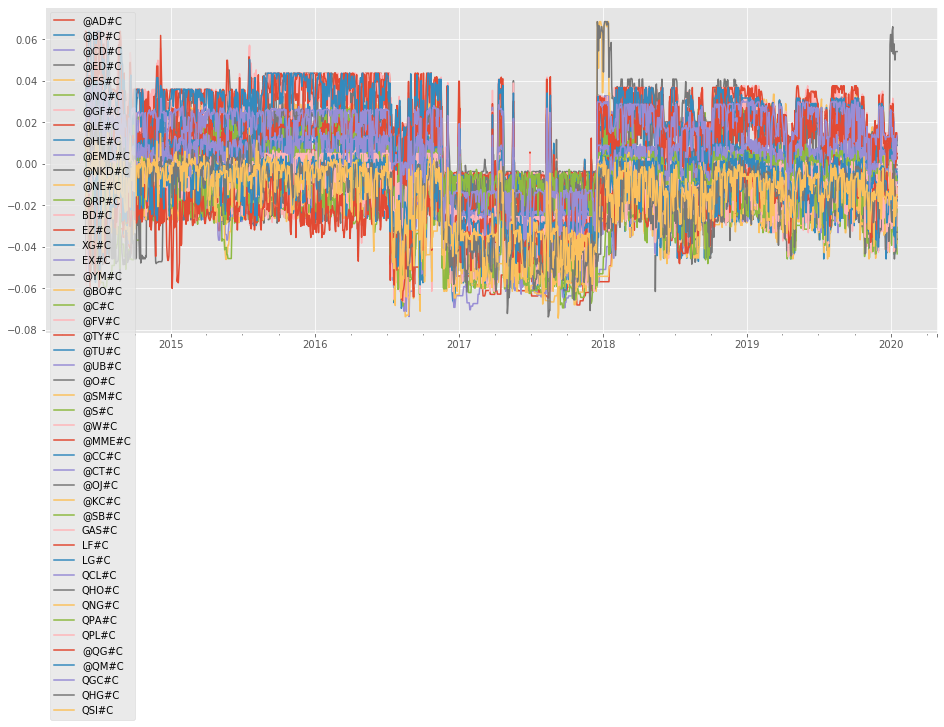

In [32]:
signal_r = signal.resample('1B').last()
signal_r.plot()


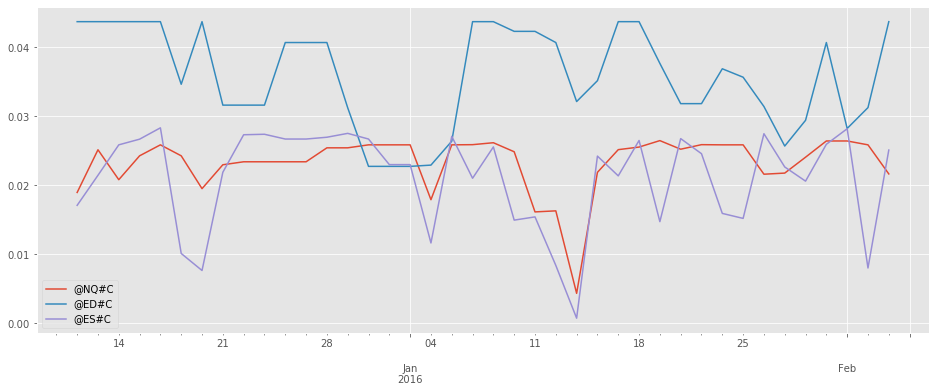

In [33]:
signal_rs = signal_r.iloc[400:440][['@NQ#C', '@ED#C', '@ES#C']].copy(deep=True)
signal_rs.plot()

In [351]:
volatilities = get_volatilities(config, close, 32)

In [352]:
# volatilities[:] = 1
nav_net, _, stats, currency_pos, profits_net = simulate_pnl(
    config, close, signal, volatilities, pos_size=50000, pos_cap_multi=1000
)
nav_net = nav_net.resample('1B').last()
currency_pos = currency_pos.resample('1B').last()
profits_net = profits_net.resample('1B').last()

In [353]:
np.sqrt(252) * (nav_net.pct_change().mean() / nav_net.pct_change().std())

0.8209259726884345

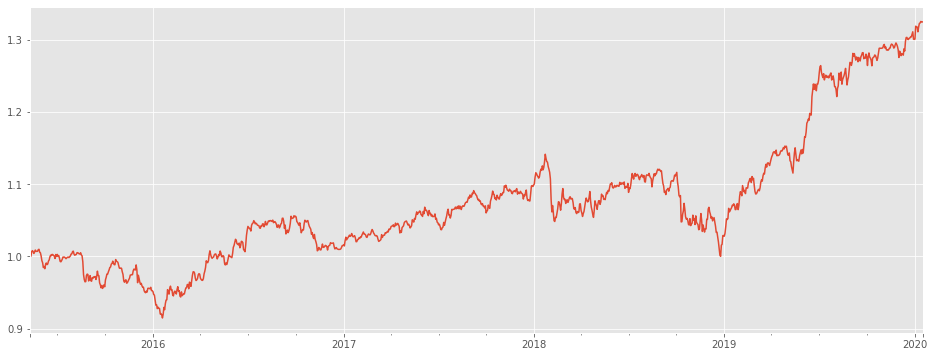

In [354]:
nav_net.plot()

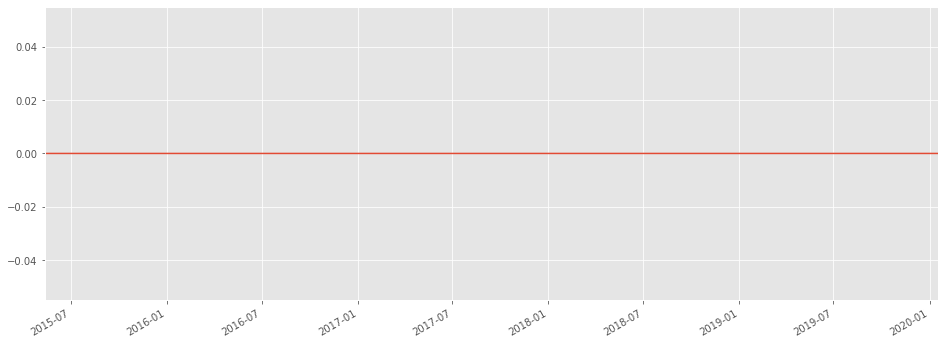

In [337]:
meany.mean(axis=1).round(3).plot()

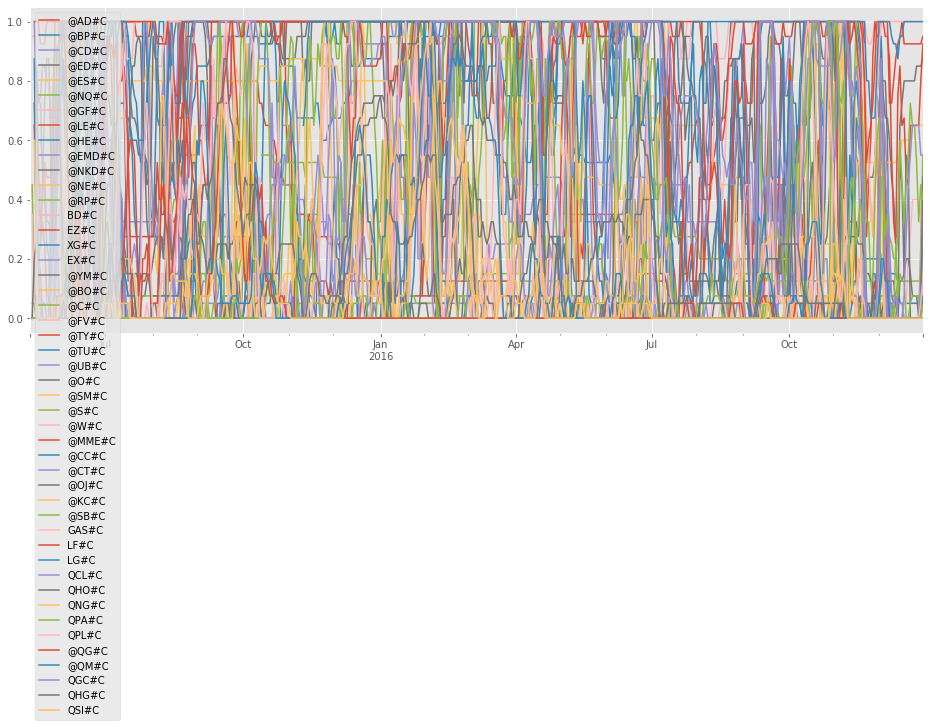

In [67]:
signal_r[:'2016'].plot()

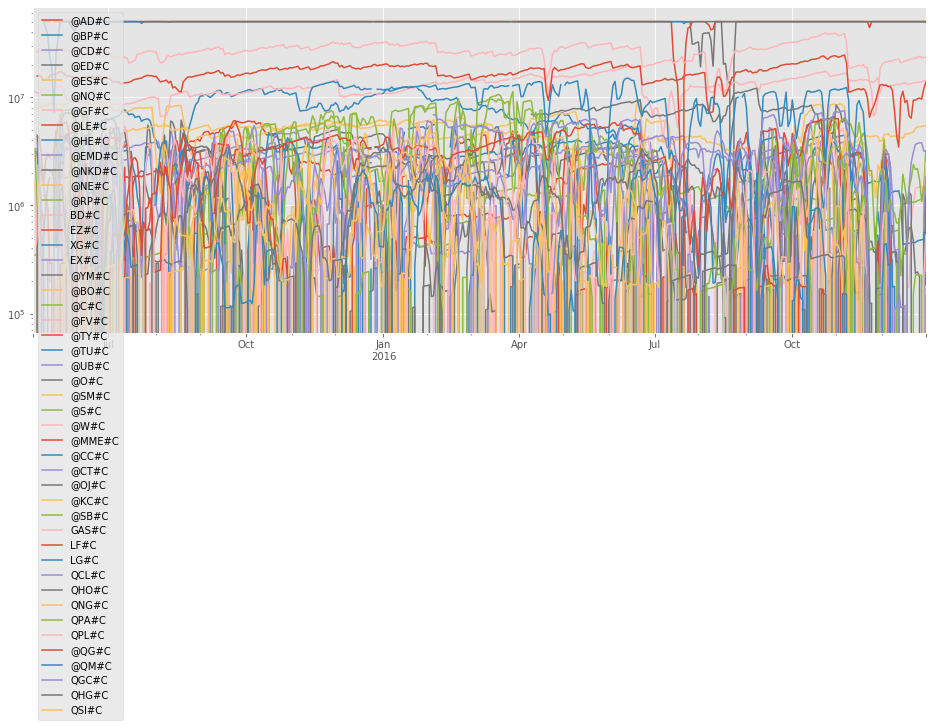

In [68]:
currency_pos[:'2016'].plot(logy=True)

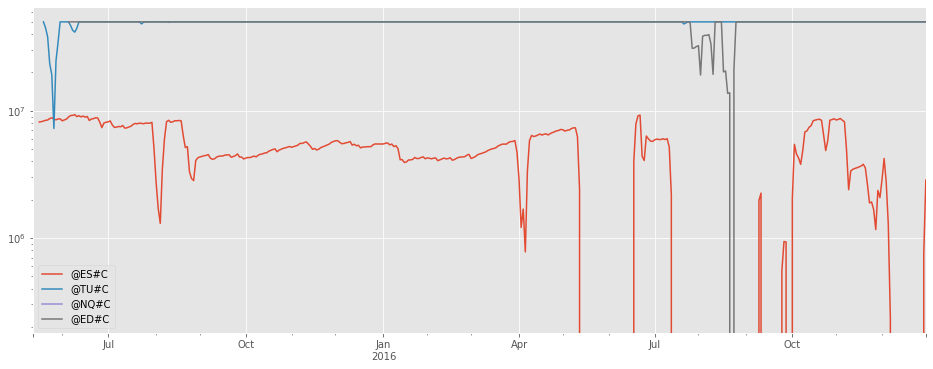

In [69]:
currency_pos[['@ES#C', '@TU#C', '@NQ#C', '@ED#C']][:'2016'].plot(logy=True)

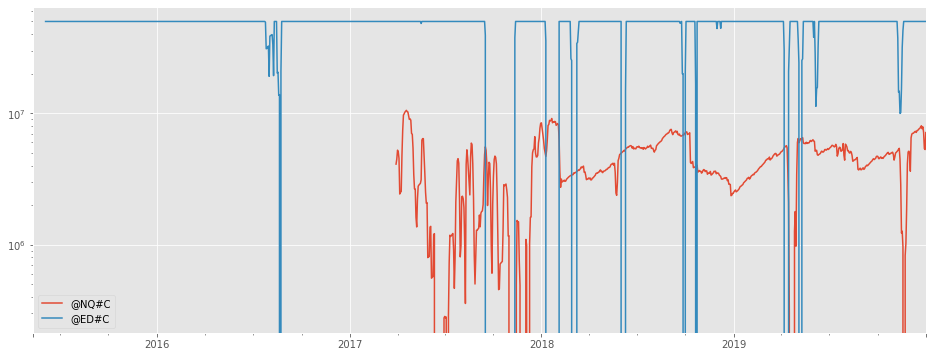

In [71]:
currency_pos[['@NQ#C', '@ED#C']][:'2019'].plot(logy=True)

In [356]:
from timeseriescv.cross_validation import PurgedWalkForwardCV

In [357]:
cv = PurgedWalkForwardCV(n_splits=10, n_test_splits=1, min_train_splits=5)

In [368]:
splits = list(cv.split(events, events['y_pred'], pred_times=events.index.to_series(), eval_times=events['t1']))
for train, test in splits:
    print(len(train), len(test))

220650 44357
264984 44357
309333 44357
353692 44357
398084 44357


In [364]:
x

array([     0,      1,      2, ..., 221198, 221249, 221253])

In [365]:
y

array([221787, 221788, 221789, ..., 266141, 266142, 266143])

In [370]:
np.array([])

array([], dtype=float64)

In [4]:
x=events.index[0]

NameError: name 'events' is not defined

In [17]:
int(x.timestamp())

1265147220

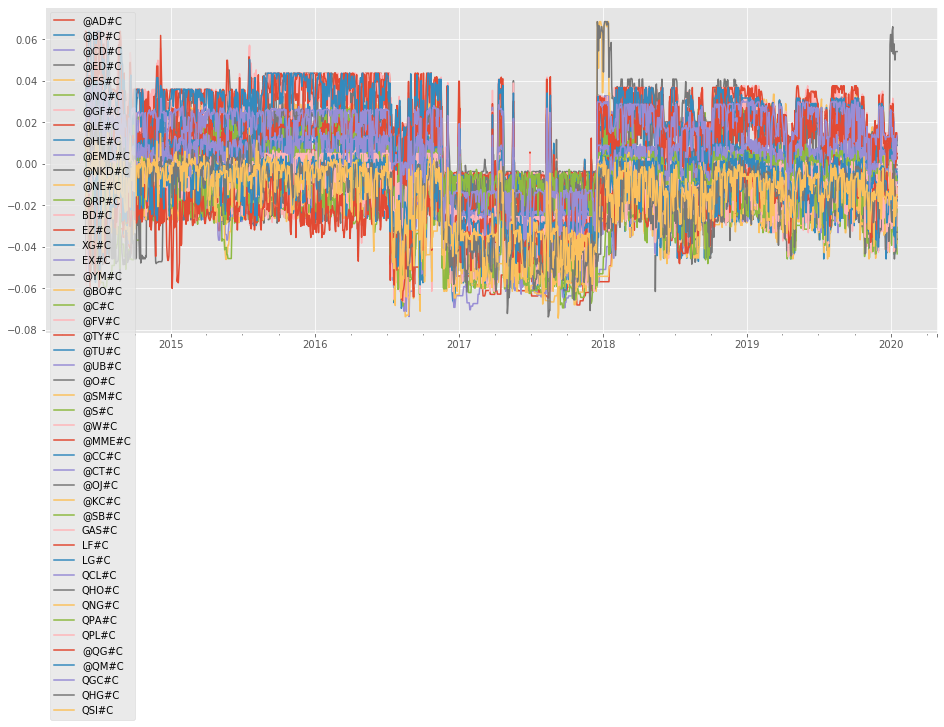

In [34]:
signal_r.plot()

In [35]:
signal_r.shape

(1471, 47)

In [95]:
def long_short_strongest_signals__(row, n):
    sorty = row.sort_values()
    shorts, longs = sorty[:n].index, sorty[-n:].index
    res = pd.Series(0, index=row.index)
    res[longs] = 1
    res[shorts] = -1
    return res

def long_short_strongest_signals(df, n):
    values = df.values
    values[np.isnan(values)] = 0

    sorty = values.argsort()

    shorts = pd.DataFrame(sorty[:, :n])
    longs = pd.DataFrame(sorty[:, -n:])

    shorts_s = shorts.apply(lambda x:df.columns[x])
    longs_s = longs.apply(lambda x:df.columns[x])

    la = longs_s.apply(lambda x: ','.join(x), axis=1).str.get_dummies(sep=',')
    sa = -shorts_s.apply(lambda x: ','.join(x), axis=1).str.get_dummies(sep=',')

    XX = la[la != 0].combine_first(sa[sa != 0])

    XX = XX.set_index(df.index)
    XX = XX.reindex(columns=df.columns)

    return XX.fillna(0)


In [96]:
sr1 = signal_r.apply(long_short_strongest_signals__, axis=1, n=3)

In [97]:
sr1

,@AD#C,@BP#C,@CD#C,@ED#C,@ES#C,@NQ#C,@GF#C,@LE#C,@HE#C,@EMD#C,...,QCL#C,QHO#C,QNG#C,QPA#C,QPL#C,@QG#C,@QM#C,QGC#C,QHG#C,QSI#C
2014-05-29,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,-1,0,0,0,0
2014-05-30,0,0,0,0,0,0,-1,0,0,0,...,0,0,0,0,-1,0,0,0,0,0
2014-06-02,-1,-1,-1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2014-06-03,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-06-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-06-05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-06-06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-06-09,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2014-06-10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,-1,0,0,0,0
2014-06-11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [99]:
sr2 = long_short_strongest_signals(signal_r, n=3)

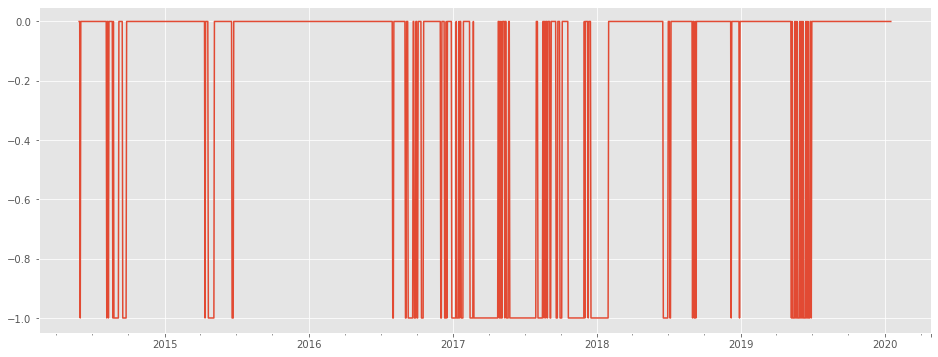

In [100]:
sr1['@AD#C'].plot()

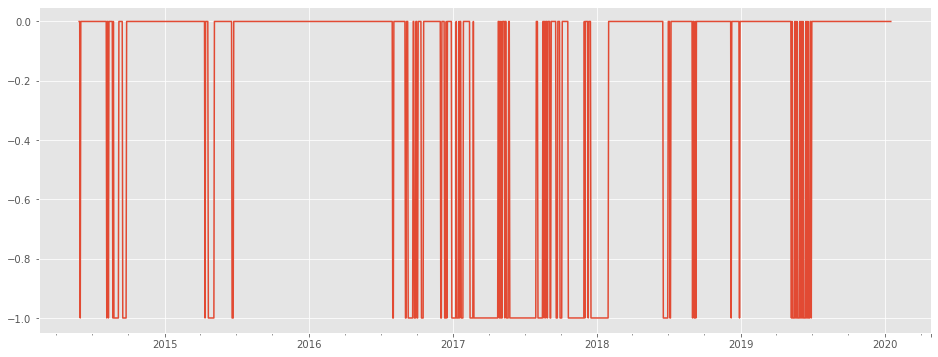

In [101]:
sr2['@AD#C'].plot()

In [103]:
sr1.describe()

,@AD#C,@BP#C,@CD#C,@ED#C,@ES#C,@NQ#C,@GF#C,@LE#C,@HE#C,@EMD#C,...,QCL#C,QHO#C,QNG#C,QPA#C,QPL#C,@QG#C,@QM#C,QGC#C,QHG#C,QSI#C
count,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,...,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000
mean,-0.212101,-0.052345,-0.164514,0.201224,0.172672,0.089055,-0.084296,-0.064582,-0.102651,-0.057104,...,0.000680,-0.029912,-0.027192,0.042148,-0.035350,-0.227056,-0.021754,0.036710,-0.027192,-0.028552
std,0.408935,0.222798,0.370867,0.425735,0.404180,0.284920,0.277926,0.245870,0.303606,0.232120,...,0.026073,0.170401,0.166828,0.272787,0.184726,0.419072,0.145929,0.188112,0.162699,0.166600
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000


In [104]:
sr2.describe()

,@AD#C,@BP#C,@CD#C,@ED#C,@ES#C,@NQ#C,@GF#C,@LE#C,@HE#C,@EMD#C,...,QCL#C,QHO#C,QNG#C,QPA#C,QPL#C,@QG#C,@QM#C,QGC#C,QHG#C,QSI#C
count,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,...,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000
mean,-0.212101,-0.052345,-0.164514,0.201224,0.172672,0.089055,-0.084296,-0.064582,-0.102651,-0.057104,...,0.000680,-0.029912,-0.027192,0.042148,-0.035350,-0.227056,-0.021754,0.036710,-0.027192,-0.028552
std,0.408935,0.222798,0.370867,0.425735,0.404180,0.284920,0.277926,0.245870,0.303606,0.232120,...,0.026073,0.170401,0.166828,0.272787,0.184726,0.419072,0.145929,0.188112,0.162699,0.166600
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000


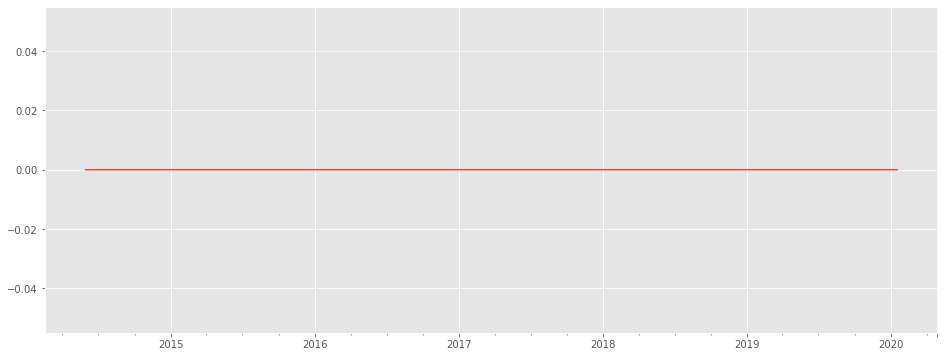

In [93]:
sr2.sum(axis=1).plot()

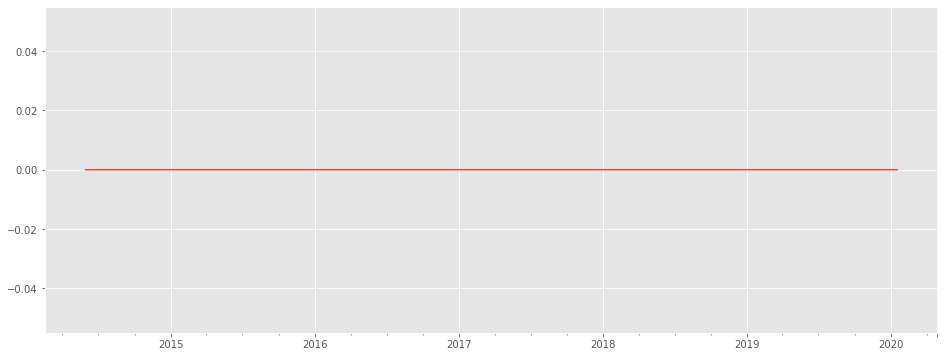

In [94]:
sr1.sum(axis=1).plot()